In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import os
import ast
import torch
import pickle
import keyboard
import numpy as np
import pandas as pd
from utils.env_utils import *
from utils.eval_utils import *
from utils.experiments_utils import *
import matplotlib.pyplot as plt
from utils.train_utils import *
from utils.sim_utils import *
from utils.couzin_utils import *
import matplotlib.image as mpimg
import matplotlib.colors as colors
from models.Generator import ModularPolicy
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from marl_aquarium.aquarium_v0 import parallel_env

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\janni\anaconda3\envs\GAIL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[KeOps] Warning : No C++ compiler found. Define CXX environment variable or install g++.
[KeOps] Warning : No C++ compiler found. You need to either define the CXX environment variable pointing to a valid compiler, or ensure that 'g++' is installed and in your PATH.
[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : No C++ compiler found. You need to either define the CXX environment variable pointing to a valid compiler, or ensure that 'g++' is installed and in your PATH.
[KeOps] Warning : No C++ compiler available to check for OpenMP support.
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


## Model Comparison using Swarm Metrics

In [8]:
# GAIL Simulation
gail_path = rf"..\data\2. Training\training\SequencePredPrey - GAIL\2026.01.10_10.36"
gail_prey_policy = ModularPolicy(features=5).to("cpu")
gail_prey_policy.load_state_dict(torch.load((os.path.join(gail_path, "prey_policy.pth")), map_location="cpu"))

gail_pred_policy = ModularPolicy(features=4).to("cpu")
gail_pred_policy.load_state_dict(torch.load((os.path.join(gail_path, "pred_policy.pth")), map_location="cpu"))

_, _, gail_metrics = run_env_simulation(visualization='off', 
                                        prey_policy=gail_prey_policy, 
                                        pred_policy=gail_pred_policy,
                                        n_prey=32, n_pred=1, 
                                        max_steps=100,
                                        pred_speed=5, prey_speed=5,
                                        area_width=50, area_height=50,
                                        max_turn = 0.25,
                                        step_size=0.5)

In [4]:
# GAIL Simulation
bc_path = rf"..\models\trained_policies\BC-Policy"
bc_prey_policy = ModularPolicy(features=5).to("cpu")
bc_prey_policy.load_state_dict(torch.load((os.path.join(bc_path, "bc_prey_policy.pt")), map_location="cpu"))

bc_pred_policy = ModularPolicy(features=4).to("cpu")
bc_pred_policy.load_state_dict(torch.load((os.path.join(bc_path, "bc_pred_policy.pt")), map_location="cpu"))

_, _, bc_metrics = run_env_simulation(visualization='off', 
                                    prey_policy=bc_prey_policy, 
                                    pred_policy=bc_pred_policy,
                                    n_prey=32, n_pred=1, 
                                    max_steps=100,
                                    pred_speed=5, prey_speed=5,
                                    area_width=50, area_height=50,
                                    max_turn = 0.25,
                                    step_size=0.5)

In [5]:
# Couzin Simulation
_, _, couzin_metrics, _ = run_couzin_simulation(visualization="off", max_steps=100, 
                                                constant_speed=5, shark_speed=5, 
                                                area_width=50, area_height=50,
                                                dt = 0.5, # step_size
                                                alpha=0.01, # social behavior - attack only
                                                theta_dot_max=0.5, theta_dot_max_shark=0.5,
                                                number_of_sharks=1, n=32)

In [6]:
random_prey_policy = ModularPolicy(features=5).to("cpu")
random_prey_policy.set_parameters()

random_pred_policy = ModularPolicy(features=4).to("cpu")
random_pred_policy.set_parameters()

_, _, random_metrics = run_env_simulation(visualization='off', 
                                        prey_policy=random_prey_policy, 
                                        pred_policy=random_pred_policy,
                                        n_prey=32, n_pred=1, 
                                        max_steps=100,
                                        pred_speed=5, prey_speed=5,
                                        area_width=50, area_height=50,
                                        max_turn = 0.25,
                                        step_size=0.5)

In [ ]:
# Load Expert Data
expert_path = rf'..\data\1. Data Processing\processed\video\expert_tensors\yolo_detected\expert_metrics_yd.pkl'
with open(expert_path, "rb") as f:
    expert_data = pickle.load(f)
expert_metrics = compute_expert_metrics(expert_data, 33)
print("Expert Metrics computed!")

Expert Metrics computed!


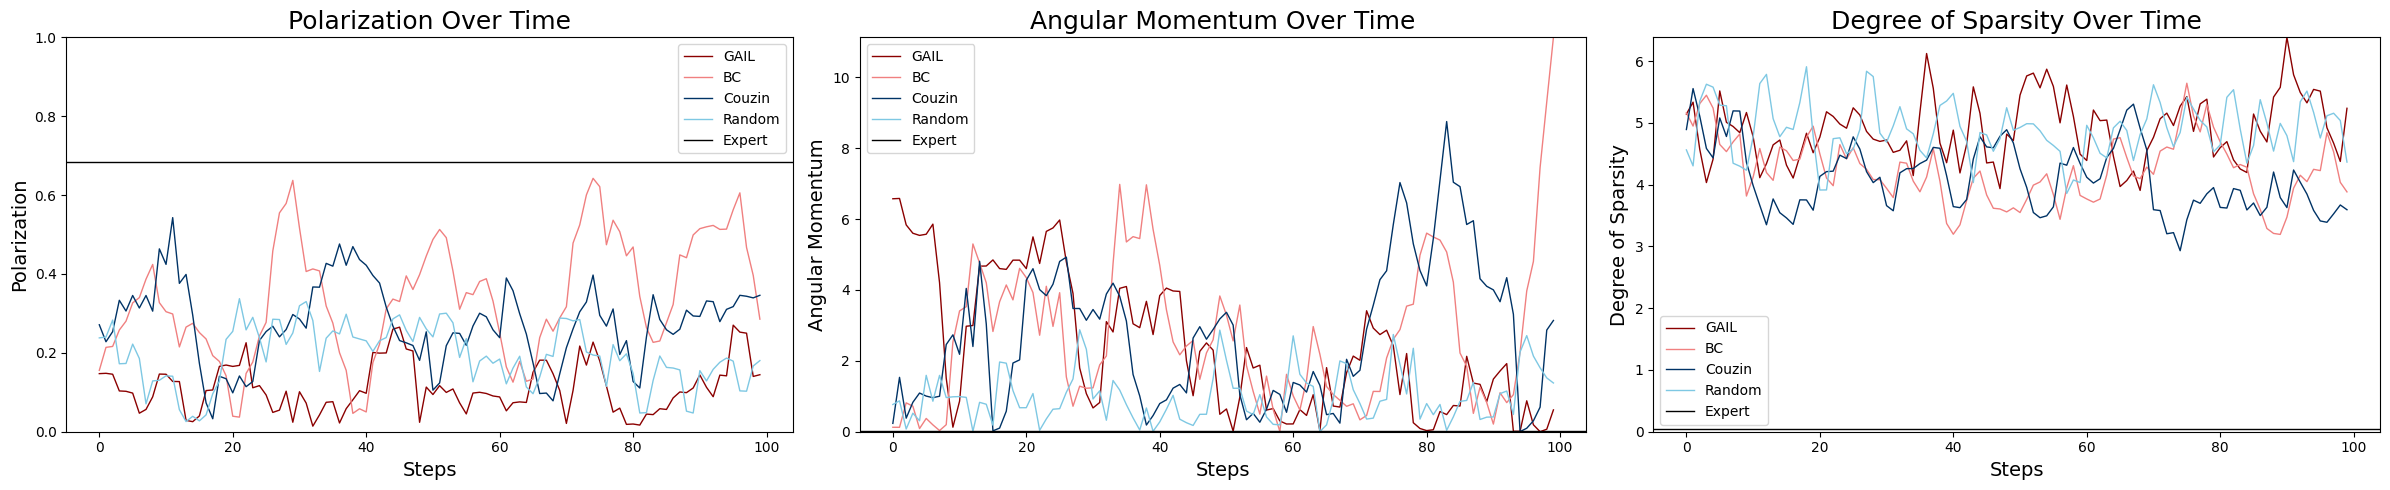

In [9]:
plot_swarm_metrics(gail_metrics, bc_metrics, couzin_metrics, random_metrics, expert_metrics)

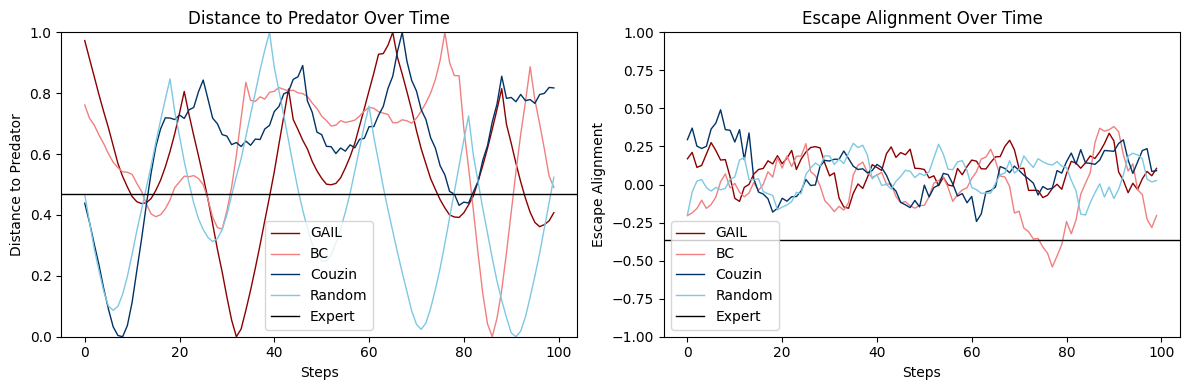

In [10]:
plot_pred_prey_metrics(gail_metrics, bc_metrics, couzin_metrics, random_metrics, expert_metrics)

## Analysis of Modular Networks

In [2]:
# GAIL Simulation
gail_path = rf"..\data\2. Training\training\SequencePredPrey - GAIL\2026.01.10_10.36"
gail_prey_policy = ModularPolicy(features=5).to("cpu")
gail_prey_policy.load_state_dict(torch.load((os.path.join(gail_path, "prey_policy.pth")), map_location="cpu"))

gail_pred_policy = ModularPolicy(features=4).to("cpu")
gail_pred_policy.load_state_dict(torch.load((os.path.join(gail_path, "pred_policy.pth")), map_location="cpu"))

pred_img_path = rf"..\data\3. Evaluation\images\predator.png"
prey_img_path = rf"..\data\3. Evaluation\images\prey.png"

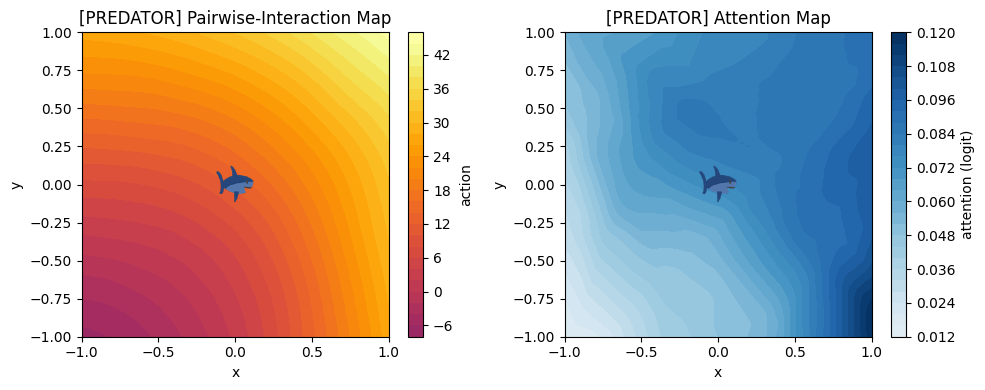

In [13]:
xs, ys, pred_action_map, pred_attn_map = compute_pin_an_maps(role="predator", pin=gail_pred_policy.pairwise, an=gail_pred_policy.attention)

plot_policy_maps(xs, ys, pred_action_map, pred_attn_map, role="predator", img_path=pred_img_path)

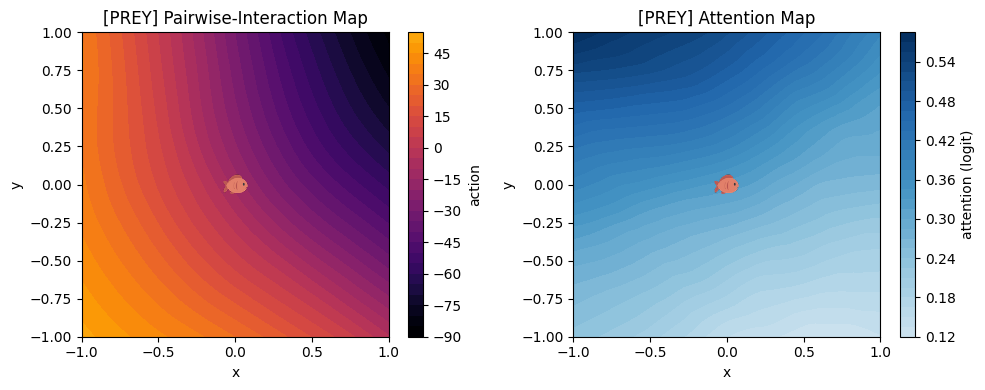

In [14]:
xs, ys, prey_action_map, prey_attn_map = compute_pin_an_maps(role="prey", pin=gail_prey_policy.pairwise, an=gail_prey_policy.attention)

plot_policy_maps(xs, ys, prey_action_map, prey_attn_map, role="prey", img_path=prey_img_path)

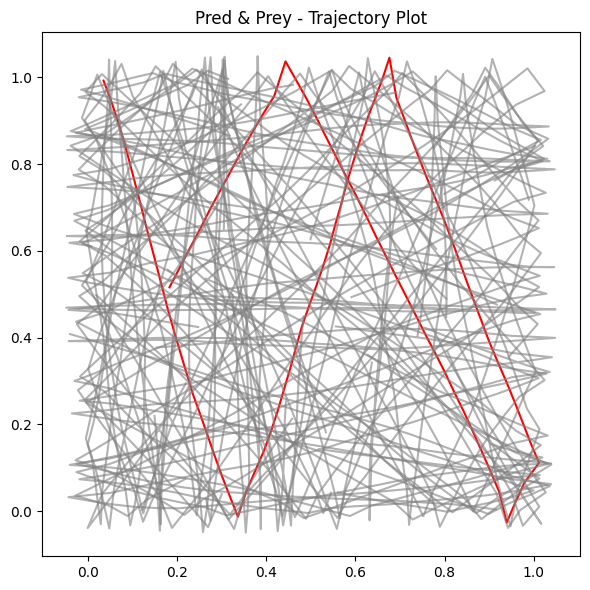

In [24]:
plot_trajectory(gail_metrics)

## Trajectory Prediction

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import os
import ast
import torch
import pickle
import keyboard
import numpy as np
import pandas as pd
from utils.env_utils import *
from utils.eval_utils import *
from utils.experiments_utils import *
import matplotlib.pyplot as plt
from utils.train_utils import *
from utils.sim_utils import *
from utils.couzin_utils import *
import matplotlib.image as mpimg
import matplotlib.colors as colors
from models.Generator import ModularPolicy
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from marl_aquarium.aquarium_v0 import parallel_env

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\janni\anaconda3\envs\GAIL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[KeOps] Warning : No C++ compiler found. Define CXX environment variable or install g++.
[KeOps] Warning : No C++ compiler found. You need to either define the CXX environment variable pointing to a valid compiler, or ensure that 'g++' is installed and in your PATH.
[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : No C++ compiler found. You need to either define the CXX environment variable pointing to a valid compiler, or ensure that 'g++' is installed and in your PATH.
[KeOps] Warning : No C++ compiler available to check for OpenMP support.
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


In [2]:
init_pool_path = rf"..\data\1. Data Processing\processed\init_pool\init_pool.pt"
init_pool = torch.load(init_pool_path).to(device)
print("Init Pool Shape:", init_pool.shape)

prey_policy = ModularPolicy(features=5).to("cpu")
prey_policy.set_parameters()

pred_policy = ModularPolicy(features=4).to("cpu")
pred_policy.set_parameters()

Init Pool Shape: torch.Size([240, 33, 3])


Step 0 | Position Error: 0.0000 ± 0.0000 | Theta Error: 0.00° ± 0.00°
Step 1 | Position Error: 0.0492 ± 0.0000 | Theta Error: 3.79° ± 0.18°
Step 2 | Position Error: 0.0981 ± 0.0001 | Theta Error: 9.41° ± 0.36°
Step 3 | Position Error: 0.1470 ± 0.0000 | Theta Error: 11.48° ± 0.29°
Step 4 | Position Error: 0.1957 ± 0.0000 | Theta Error: 12.68° ± 0.34°
Step 5 | Position Error: 0.2452 ± 0.0001 | Theta Error: 13.34° ± 0.39°
Step 6 | Position Error: 0.2907 ± 0.0001 | Theta Error: 18.91° ± 0.43°
Step 7 | Position Error: 0.3327 ± 0.0003 | Theta Error: 24.47° ± 0.50°
Step 8 | Position Error: 0.3648 ± 0.0010 | Theta Error: 38.87° ± 1.33°
Step 9 | Position Error: 0.3927 ± 0.0010 | Theta Error: 47.31° ± 1.18°


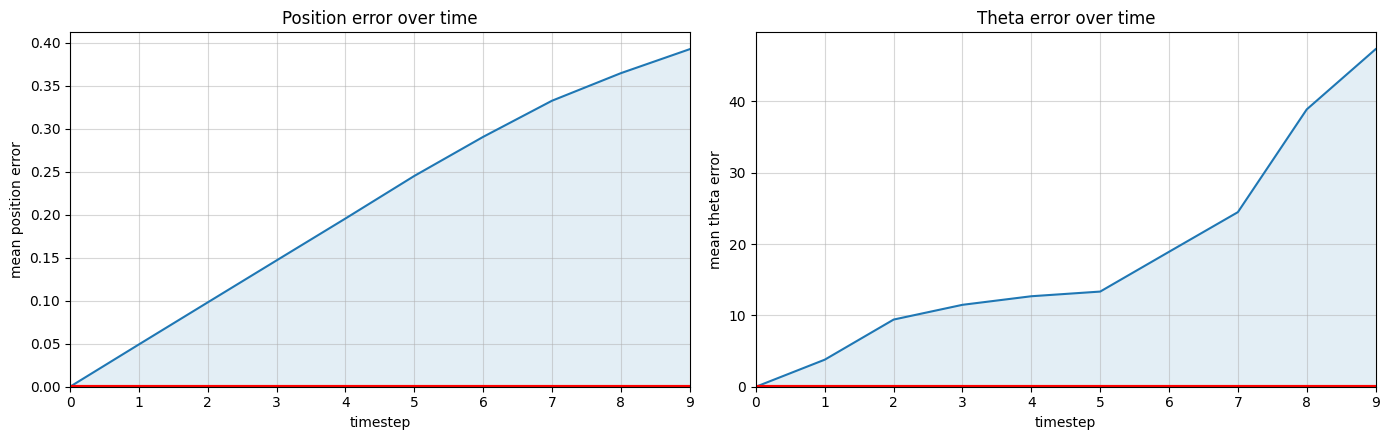

In [ ]:
clips = init_pool.view(24, 10, 33, 3)
clip=23

clip = clips[clip]
init_pos = clip[0].clone()


metric_list = []
for i in range(100):
    _, _, metrics = run_env_simulation(visualization='off', 
                                        init_pool=init_pos, experiment=True,
                                        prey_policy=prey_policy, 
                                        pred_policy=pred_policy,
                                        n_prey=32, n_pred=1, 
                                        max_steps=10,
                                        pred_speed=5, prey_speed=5,
                                        area_width=50, area_height=50,
                                        max_turn = 0.25,
                                        step_size=0.5)
    metric_list.append(metrics)
    
gen_xs = np.array([[step["xs"] for step in rollout_metrics] for rollout_metrics in metric_list], dtype=np.float32)
gen_ys = np.array([[step["ys"] for step in rollout_metrics] for rollout_metrics in metric_list], dtype=np.float32)
gen_thetas = np.array([[step["theta"] for step in rollout_metrics] for rollout_metrics in metric_list], dtype=np.float32)

exp_xs = clip[:, :, 0].detach().cpu().numpy().astype(np.float32)
exp_ys = clip[:, :, 1].detach().cpu().numpy().astype(np.float32)
exp_thetas = clip[:, :, 2] .detach().cpu().numpy().astype(np.float32)

#gen (10,10,33), exp (10,33)
dx = gen_xs - exp_xs[None, :, :]
dy = gen_ys - exp_ys[None, :, :]

# euclidean distance
position_error = np.sqrt(dx**2 + dy**2) #(10, 10, 33)

# offset in degrees
gen_theta_deg = (np.rad2deg(gen_thetas) + 180) % 360 - 180
exp_theta_deg = (np.rad2deg(exp_thetas) + 180) % 360 - 180
theta_diff = (gen_theta_deg - exp_theta_deg[None, :, :] + 180) % 360 - 180
theta_error = np.abs(theta_diff) #(10, 10, 33)

# mean error over agent dimension
position_error_agents = position_error.mean(axis=2) #(10, 10)
theta_error_agents = theta_error.mean(axis=2) #(10, 10)

# position error per time step
step_position_error = position_error_agents.mean(axis=0)
step_position_std  = position_error_agents.std(axis=0)

# theta error per time step
step_theta_error = theta_error_agents.mean(axis=0)
step_theta_std  = theta_error_agents.std(axis=0)

for step in range(position_error_agents.shape[1]):
    print(f"Step {step} | Position Error: {step_position_error[step]:.4f} ± {step_position_std[step]:.4f} | "
          f"Theta Error: {step_theta_error[step]:.2f}° ± {step_theta_std[step]:.2f}°")
    

t = np.arange(step_position_error.shape[0])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4.5), sharex=True)

# Position error
ax1.plot(t, step_position_error)
ax1.fill_between(t, 0, step_position_error, alpha=0.12)
ax1.axhline(0, color="red", linewidth=3)
ax1.grid(True, linewidth=0.8, alpha=0.5)
ax1.set_xlim(0, t[-1])
ax1.set_ylim(0)
ax1.set_xlabel("timestep")
ax1.set_ylabel("mean position error")
ax1.set_title("Position error over time")

# Theta error
ax2.plot(t, step_theta_error)
ax2.fill_between(t, 0, step_theta_error, alpha=0.12)
ax2.axhline(0, color="red", linewidth=3)
ax2.grid(True, linewidth=0.8, alpha=0.5)
ax2.set_xlim(0, t[-1])
ax2.set_ylim(0)
ax2.set_xlabel("timestep")
ax2.set_ylabel("mean theta error")
ax2.set_title("Theta error over time")

plt.tight_layout()
plt.show()

Step 0 | Position Error: 0.0000 ± 0.0000 | Theta Error: 0.00° ± 0.00°
Step 1 | Position Error: 0.0492 ± 0.0003 | Theta Error: 3.21° ± 2.03°
Step 2 | Position Error: 0.0982 ± 0.0006 | Theta Error: 5.86° ± 3.28°
Step 3 | Position Error: 0.1456 ± 0.0021 | Theta Error: 9.84° ± 4.16°
Step 4 | Position Error: 0.1923 ± 0.0037 | Theta Error: 13.63° ± 5.23°
Step 5 | Position Error: 0.2359 ± 0.0070 | Theta Error: 20.04° ± 7.50°
Step 6 | Position Error: 0.2738 ± 0.0147 | Theta Error: 31.02° ± 13.50°
Step 7 | Position Error: 0.3062 ± 0.0250 | Theta Error: 41.71° ± 18.99°
Step 8 | Position Error: 0.3350 ± 0.0355 | Theta Error: 51.74° ± 23.08°
Step 9 | Position Error: 0.3552 ± 0.0423 | Theta Error: 67.73° ± 22.56°


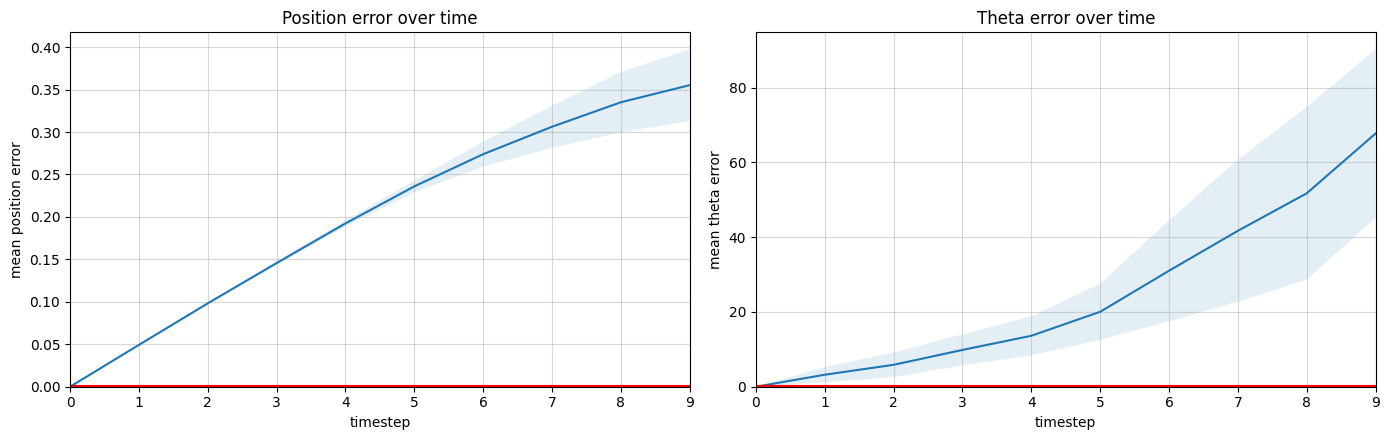

In [57]:
clips = init_pool.view(24, 10, 33, 3)

clip_position_error = []
clip_theta_error = []

for clip in range(clips.shape[0]):
    clip = clips[clip]
    init_pos = clip[0].clone()


    metric_list = []
    for i in range(50):
        _, _, metrics = run_env_simulation(visualization='off', 
                                            init_pool=init_pos, experiment=True,
                                            prey_policy=prey_policy, 
                                            pred_policy=pred_policy,
                                            n_prey=32, n_pred=1, 
                                            max_steps=10,
                                            pred_speed=5, prey_speed=5,
                                            area_width=50, area_height=50,
                                            max_turn = 0.25,
                                            step_size=0.5)
        metric_list.append(metrics)
        
    gen_xs = np.array([[step["xs"] for step in rollout_metrics] for rollout_metrics in metric_list], dtype=np.float32)
    gen_ys = np.array([[step["ys"] for step in rollout_metrics] for rollout_metrics in metric_list], dtype=np.float32)
    gen_thetas = np.array([[step["theta"] for step in rollout_metrics] for rollout_metrics in metric_list], dtype=np.float32)

    exp_xs = clip[:, :, 0].detach().cpu().numpy().astype(np.float32)
    exp_ys = clip[:, :, 1].detach().cpu().numpy().astype(np.float32)
    exp_thetas = clip[:, :, 2] .detach().cpu().numpy().astype(np.float32)

    #gen (10,10,33), exp (10,33)
    dx = gen_xs - exp_xs[None, :, :]
    dy = gen_ys - exp_ys[None, :, :]

    # euclidean distance
    position_error = np.sqrt(dx**2 + dy**2) #(10, 10, 33)

    # offset in degrees
    gen_theta_deg = (np.rad2deg(gen_thetas) + 180) % 360 - 180
    exp_theta_deg = (np.rad2deg(exp_thetas) + 180) % 360 - 180
    theta_diff = (gen_theta_deg - exp_theta_deg[None, :, :] + 180) % 360 - 180
    theta_error = np.abs(theta_diff) #(10, 10, 33)

    # mean error over agent dimension
    position_error_agents = position_error.mean(axis=2) #(10, 10)
    theta_error_agents = theta_error.mean(axis=2) #(10, 10)

    # position error per time step
    step_position_error = position_error_agents.mean(axis=0)
    step_position_std  = position_error_agents.std(axis=0)
    clip_position_error.append(step_position_error)

    # theta error per time step
    step_theta_error = theta_error_agents.mean(axis=0)
    step_theta_std  = theta_error_agents.std(axis=0)
    clip_theta_error.append(step_theta_error)
        
# stack errors
clip_position_error = np.stack(clip_position_error, axis=0)  # (24, T)
clip_theta_error = np.stack(clip_theta_error, axis=0)     # (24, T)

clip_position_error_mean = clip_position_error.mean(axis=0)
clip_position_error_std  = clip_position_error.std(axis=0)
clip_theta_error_mean = clip_theta_error.mean(axis=0)
clip_theta_error_std  = clip_theta_error.std(axis=0)

for step in range(position_error_agents.shape[1]):
    print(f"Step {step} | Position Error: {clip_position_error_mean[step]:.4f} ± {clip_position_error_std[step]:.4f} | "
          f"Theta Error: {clip_theta_error_mean[step]:.2f}° ± {clip_theta_error_std[step]:.2f}°")

t = np.arange(step_position_error.shape[0])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4.5), sharex=True)

# Position error
ax1.plot(t, clip_position_error_mean)
ax1.fill_between(t, clip_position_error_mean - clip_position_error_std, clip_position_error_mean + clip_position_error_std, alpha=0.12)
ax1.axhline(0, color="red", linewidth=3)
ax1.grid(True, linewidth=0.8, alpha=0.5)
ax1.set_xlim(0, t[-1])
ax1.set_ylim(0)
ax1.set_xlabel("timestep")
ax1.set_ylabel("mean position error")
ax1.set_title("Position error over time")

# Theta error
ax2.plot(t, clip_theta_error_mean)
ax2.fill_between(t, clip_theta_error_mean - clip_theta_error_std, clip_theta_error_mean + clip_theta_error_std, alpha=0.12)
ax2.axhline(0, color="red", linewidth=3)
ax2.grid(True, linewidth=0.8, alpha=0.5)
ax2.set_xlim(0, t[-1])
ax2.set_ylim(0)
ax2.set_xlabel("timestep")
ax2.set_ylabel("mean theta error")
ax2.set_title("Theta error over time")

plt.tight_layout()
plt.show()

In [58]:
def align_to_start_heading(x, y, theta):
    # convert to relative coordinates with start at (0,0)
    start_x = x[0]
    start_y = y[0]
    x_norm = x - start_x
    y_norm = y - start_y

    # rotate so the heading points "up" (positive y-axis)
    rotation_angle = (np.pi / 2.0) - theta
    cos_angle = np.cos(rotation_angle)
    sin_angle = np.sin(rotation_angle)

    x_rotated = cos_angle * x_norm - sin_angle * y_norm
    y_rotated = sin_angle * x_norm + cos_angle * y_norm

    return x_rotated, y_rotated


def trajectory_plot(ax, agent_idx, role):
    n_rollouts, agents, coordinates = gen_xs.shape

    rollouts = np.arange(n_rollouts)

    all_x = []
    all_y = []

    # Draw generated trajectories in grey
    for r in rollouts:
        x = np.asarray(gen_xs[r, :, agent_idx], dtype=np.float32)
        y = np.asarray(gen_ys[r, :, agent_idx], dtype=np.float32)
        theta = float(gen_thetas[r, 0, agent_idx])
        x_rotated, y_rotated = align_to_start_heading(x, y, theta)
        all_x.append(x_rotated)
        all_y.append(y_rotated)

        ax.plot(x_rotated, y_rotated, color="0.55", linewidth=0.9, alpha=0.25, zorder=1)

    # Draw expert in red
    exp_x = np.asarray(exp_xs[:, agent_idx], dtype=np.float32)
    exp_y = np.asarray(exp_ys[:, agent_idx], dtype=np.float32)
    exp_theta = float(exp_thetas[0, agent_idx])
    align_exp_x, align_exp_y = align_to_start_heading(exp_x, exp_y, exp_theta)
    all_x.append(align_exp_x) 
    all_y.append(align_exp_y)

    ax.plot(align_exp_x, align_exp_y, color="red", linewidth=5.0, alpha=1.0, zorder=10)
    ax.scatter(align_exp_x, align_exp_y, s=30, color="red", alpha=1.0, zorder=11)

    # Set startpoint
    ax.scatter([0.0], [0.0], s=20, color="black", zorder=12)
    ax.set_title(role.upper())
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("auto")

    # widen x-limits even if tight
    x_all = np.concatenate(all_x)
    y_all = np.concatenate(all_y)

    x_abs = float(np.max(np.abs(x_all))) if x_all.size else 0.0
    y_min = float(np.min(y_all)) if y_all.size else 0.0
    y_max = float(np.max(y_all)) if y_all.size else 1.0

    x_span = max(0.10, 1.15 * x_abs)
    ax.set_xlim(-x_span, x_span)

    y_pad = 0.02 * (y_max - y_min + 1e-9)
    ax.set_ylim(y_min - y_pad, y_max + y_pad)


In [61]:
agent_idx = 0
n_rollouts, agents, coordinates = gen_xs.shape

rollouts = np.arange(n_rollouts)

def mean_step_length(x, y):
    dx = np.diff(x); dy = np.diff(y)
    return float(np.mean(np.sqrt(dx*dx + dy*dy)))

gen_step = np.mean([mean_step_length(gen_xs[r,:,agent_idx], gen_ys[r,:,agent_idx]) for r in range(n_rollouts)])
exp_step = mean_step_length(exp_xs[:,agent_idx], exp_ys[:,agent_idx])
scale = gen_step / (exp_step + 1e-9)

In [62]:
scale

np.float64(418.1646678078557)

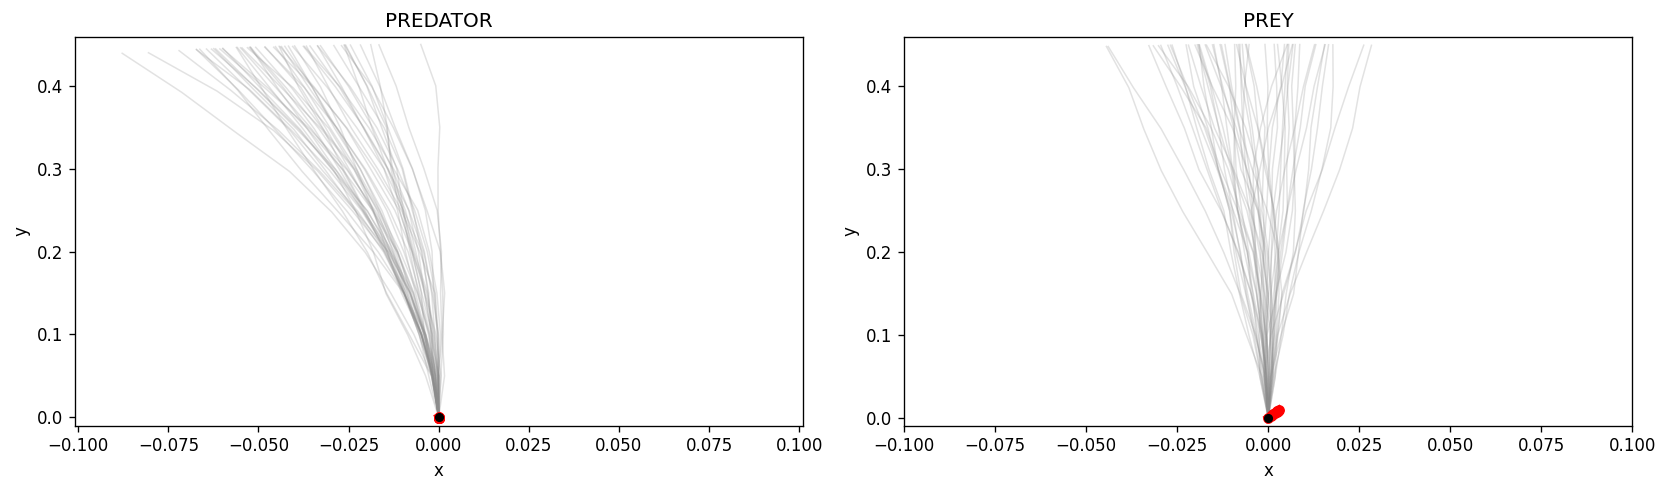

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4.2), dpi=120)  # wider figure

trajectory_plot(axes[0], agent_idx=0, role="Predator")
trajectory_plot(axes[1], agent_idx=1, role="Prey")

plt.tight_layout()
plt.show()

## Social Role Analysis